In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')

from tqdm import tqdm
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, SpatialDropout1D, Bidirectional, Activation, GRU
from tensorflow.keras.initializers import Constant

import warnings

warnings.simplefilter('ignore')

import requests
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import jieba
import re

In [2]:
file_path = 'C-Tweets_classified.xlsx'
data = pd.read_excel(file_path)

In [3]:
import requests

# URL to a Chinese stopword list on GitHub
url = "https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt"

# Download the stopword list
response = requests.get(url)
with open('chinese_stopwords.txt', 'wb') as f:
    f.write(response.content)

# Load stopwords into a set
with open('chinese_stopwords.txt', 'r', encoding='utf-8') as f:
    chinese_stopwords = set(line.strip() for line in f)


In [4]:
data.head()

,Unnamed: 0,Text,Tag,Class
0,0,DDos攻,DDoS,0
1,1,靠谱黑客（点我头像主页找我解决！）\n专业黑客*\n#入侵网站\n在线 接 单\n 黑客 \...,DDoS,0
2,2,名大附属 DDOS攻撃 湯浅郁也 捏造 名大附属 公文書偽造罪 名大附属 遺棄罪 名大附,DDoS,0
3,3,RT @hedy_wallis: 怎么修改成绩_怎么找黑客改成绩_ddos攻击\n找黑客改成...,DDoS,0
4,4,@baizhiyundong 建议官网套一层CloudFlare，不然容易被共匪DDoS\n...,DDoS,1


In [5]:
data.Text[4]

'@baizhiyundong 建议官网套一层CloudFlare，不然容易被共匪DDoS\n另外，目前中国大陆已全面屏蔽该域名，微信也已显示停止访问'

In [6]:
threat = data[data['Class'] == 0].shape[0]
neutral = data[data['Class'] == 1].shape[0]
non_threat = data[data['Class'] == 2].shape[0]

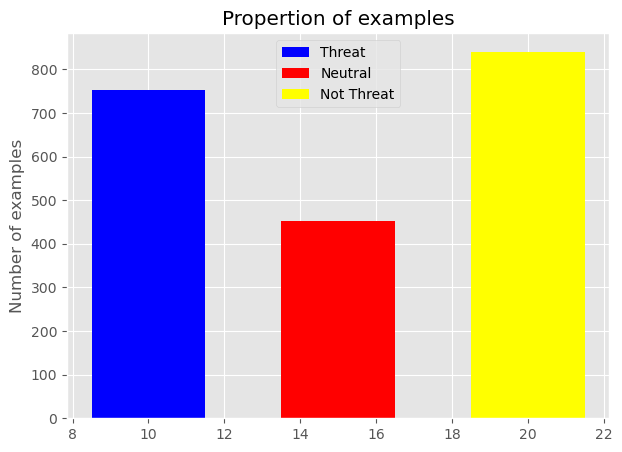

In [7]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,threat,3, label="Threat", color='blue')
plt.bar(15,neutral,3, label="Neutral", color='red')
plt.bar(20,non_threat,3, label="Not Threat", color='yellow')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

In [8]:
def length(text):
    return len(text)

In [9]:
data['length'] = data['Text'].apply(length)

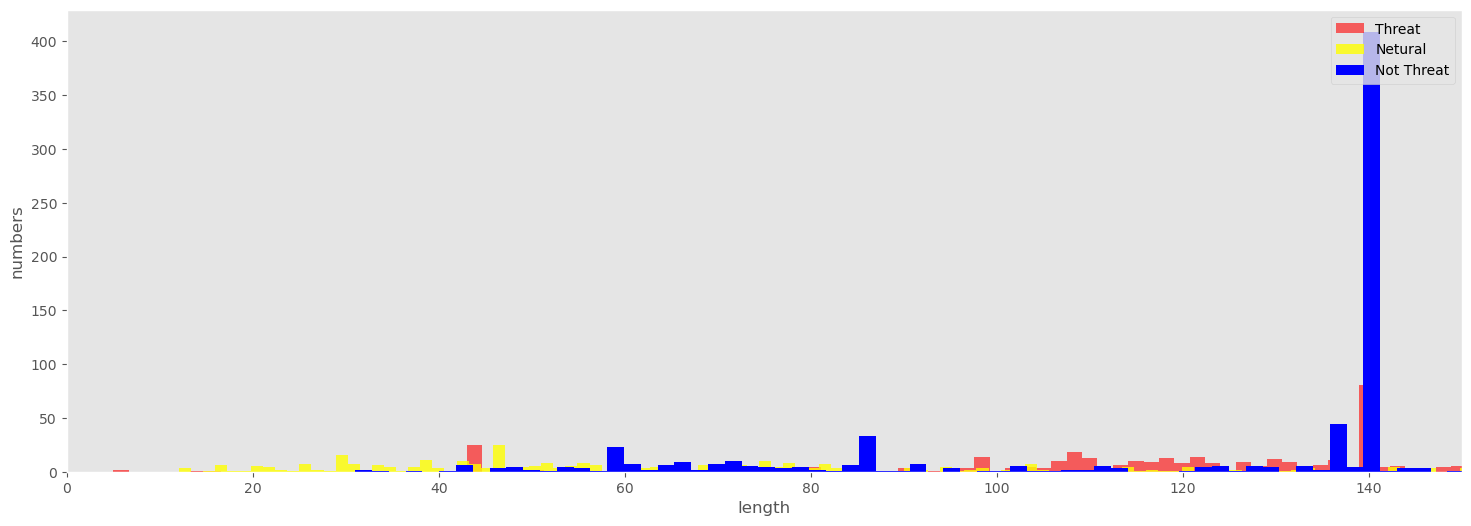

In [10]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(data[data['Class'] == 0]['length'], alpha = 0.6, bins=bins, label='Threat', color='red')
plt.hist(data[data['Class'] == 1]['length'], alpha = 0.8, bins=bins, label='Netural', color='yellow')
plt.hist(data[data['Class'] == 2]['length'], alpha = 1, bins=bins, label='Not Threat', color='blue')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

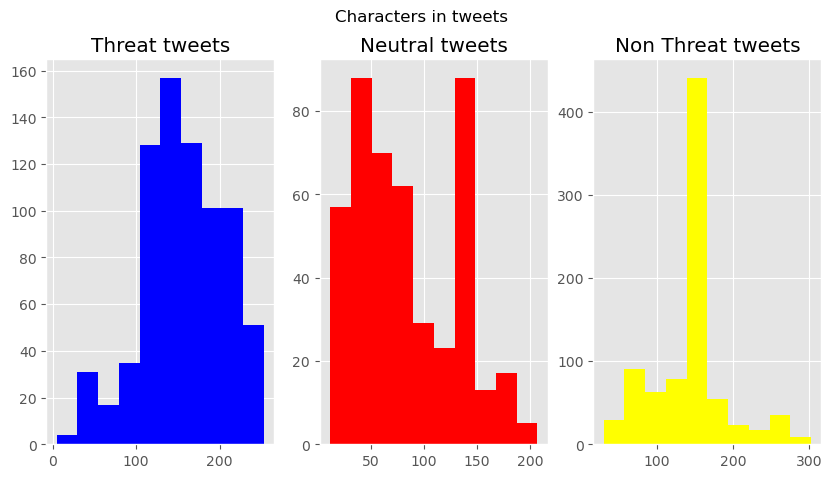

In [11]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(10,5))
tweet_len=data[data['Class']==0]['Text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('Threat tweets')
tweet_len=data[data['Class']==1]['Text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Neutral tweets')
tweet_len=data[data['Class']==2]['Text'].str.len()
ax3.hist(tweet_len,color='yellow')
ax3.set_title('Non Threat tweets')
fig.suptitle('Characters in tweets')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

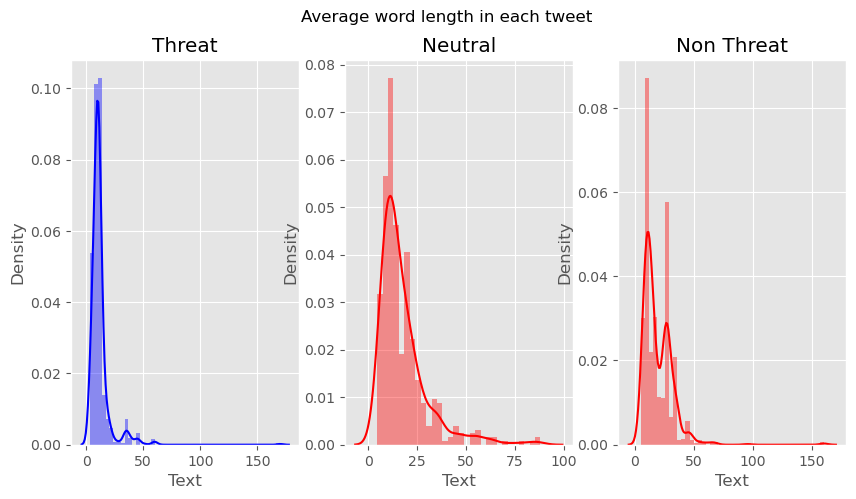

In [12]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
word=data[data['Class']==0]['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('Threat')
word=data[data['Class']==1]['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Neutral')
word=data[data['Class']==2]['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='red')
ax3.set_title('Non Threat')
fig.suptitle('Average word length in each tweet')

In [5]:
# Function to clean and preprocess Chinese text
import re
import jieba
def preprocess_text_chinese(text):
    # Remove special characters and links
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[A-Za-z]', '', text)
    text = re.sub(r'[^A-Za-z0-9\u4e00-\u9fa5]', '', text)  # Retain Chinese characters and numbers

    # Word segmentation using jieba
    tokens = jieba.cut(text)
    tokens = [word for word in tokens if word not in chinese_stopwords]  # Remove stopwords

    return ' '.join(tokens)

In [6]:
data['Text'] = data['Text'].apply(preprocess_text_chinese)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\W10165~1\AppData\Local\Temp\jieba.cache
Loading model cost 2.005 seconds.
Prefix dict has been built successfully.


In [7]:
# Step 4: Prepare Data for Model
max_words = 5000  
max_len = 100  

X = data['Text'].tolist()
y = data['Class'].values


In [8]:
print(data['Class'].value_counts())

2    841
0    754
1    452
Name: Class, dtype: int64


In [9]:
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)


In [11]:
embedding_index = {}
with open('glove.twitter.27B.200d.txt', 'r', encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embedding_index[word] = coefs


embedding_dim = 200
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

In [12]:
for word, index in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# RNN Code

In [65]:
# Step 6: Build Model for Multi-Class Classification
num_classes = len(np.unique(y))  # Number of unique classes

model_RNN = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim,
              weights = [embedding_matrix],
              input_length=max_len,
              trainable = True),
    Bidirectional(SimpleRNN(128, return_sequences=True, kernel_regularizer=l2(0.01))),  # Keep return_sequences=True to pass 3D output to the next layer
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(0.01))),  # Keep return_sequences=True for the same reason
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model using a loss function suitable for multi-class classification
model_RNN.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

model_RNN.build(input_shape=(None, max_len))  # Explicitly build the model with input shape

model_RNN.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ (None, 100, 200)            │       1,125,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_50 (Bidirectional)     │ (None, 100, 256)            │          84,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 100, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_51 (Bidirectional)     │ (None, 100, 128)            │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 100, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_52 (Bidirectional)     │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,278,227 (4.88 MB)

 Trainable params: 1,278,227 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Step 7: Train Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
callbacks = [early_stopping]
history_RNN= model_RNN.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.4943 - loss: 3.2631 - val_accuracy: 0.5561 - val_loss: 1.1267
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.6904 - loss: 0.9106 - val_accuracy: 0.6683 - val_loss: 0.9507
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8299 - loss: 0.6842 - val_accuracy: 0.8073 - val_loss: 0.8811
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8957 - loss: 0.5259 - val_accuracy: 0.7878 - val_loss: 0.8176
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8946 - loss: 0.6886 - val_accuracy: 0.7951 - val_loss: 1.1467
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8944 - loss: 0.8337 - val_accuracy: 0.8000 - val_loss: 1.0785
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9293 - loss: 0.7115 - val_accuracy: 0.8073 - val_loss: 0.9547
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9201 - loss: 0.5731 - val_accuracy: 0.74

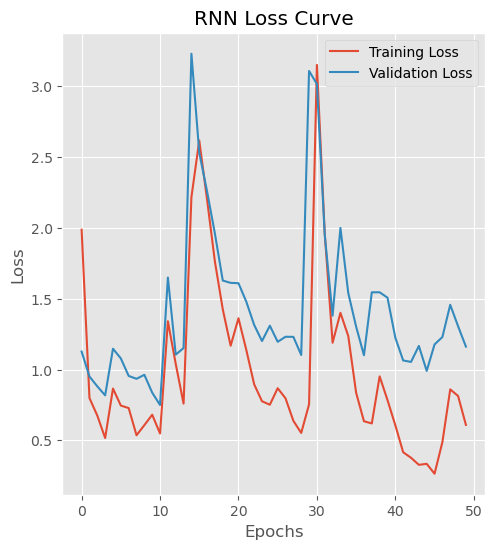

In [67]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_RNN.history['loss'], label = 'Training Loss')
plt.plot(history_RNN.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Loss Curve')
plt.legend()

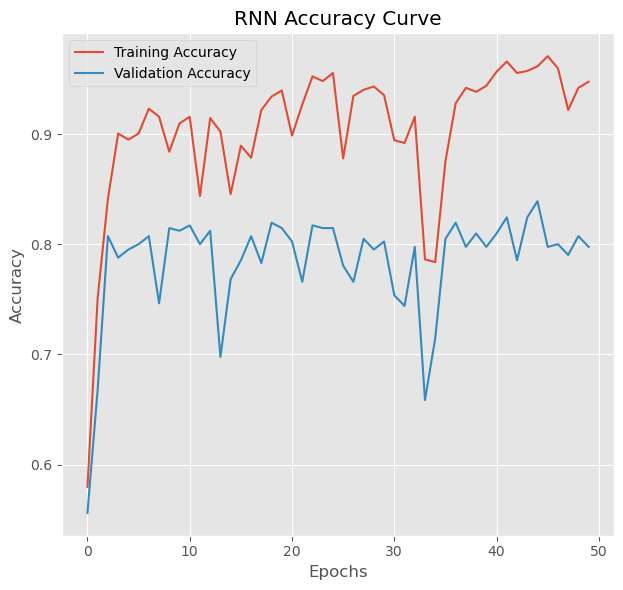

In [68]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_RNN.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_RNN.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('RNN Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# LSTM Code

In [58]:
 # Using LSTM for better performance
from keras.regularizers import l2
num_classes = len(np.unique(y))
model_lstm = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim,
              weights = [embedding_matrix],
              input_length=max_len,
              trainable = True),
    Bidirectional(LSTM(128, return_sequences = True, kernel_regularizer=l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(num_classes, activation = 'softmax')
])

# Use categorical crossentropy for multi-class classification
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

model_lstm.build(input_shape=(None, max_len))  # Explicitly build the model with input shape

model_lstm.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ (None, 100, 200)            │       1,125,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_41 (Bidirectional)     │ (None, 100, 256)            │         336,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 100, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_42 (Bidirectional)     │ (None, 100, 128)            │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 100, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_43 (Bidirectional)     │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,542,931 (5.89 MB)

 Trainable params: 1,542,931 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# callbacks=[early_stopping]
history_lstm = model_lstm.fit(X_train, y_train, 
                              epochs = 50, batch_size = 32, validation_split = 0.2)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 0.4824 - loss: 8.3259 - val_accuracy: 0.6616 - val_loss: 5.4990
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.7120 - loss: 4.8570 - val_accuracy: 0.6646 - val_loss: 3.5061
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.6919 - loss: 3.1503 - val_accuracy: 0.7195 - val_loss: 2.3602
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.7634 - loss: 2.0826 - val_accuracy: 0.7805 - val_loss: 1.6623
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.8962 - loss: 1.4121 - val_accuracy: 0.7896 - val_loss: 1.3302
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.8968 - loss: 1.0710 - val_accuracy: 0.7988 - val_loss: 1.1348
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.9270 - loss: 0.8498 - val_accuracy: 0.7896 - val_loss: 1.0625
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.9265 - loss: 0.7036 - val_accuracy: 0

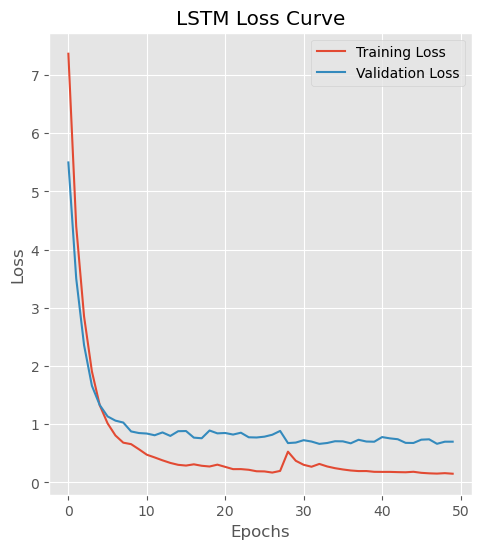

In [60]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label = 'Training Loss')
plt.plot(history_lstm.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Loss Curve')
plt.legend()

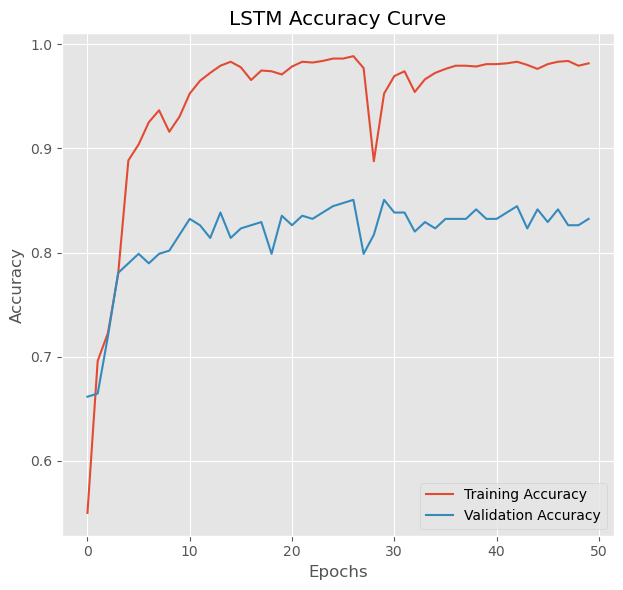

In [61]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# GRU Model

In [50]:
# Number of unique classes
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
num_classes = len(np.unique(y))

# Define the GRU model
model_GRU = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, 
              output_dim=embedding_dim,
              weights = [embedding_matrix],
              input_length=max_len,
              trainable = True),  # Corrected output_dim
    Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(64, return_sequences = True, kernel_regularizer=l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(32, return_sequences = False, kernel_regularizer=l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')  # Added comma to separate the layers properly
])

# Compile the model
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
# Explicitly build the model with input shape
model_GRU.build(input_shape=(None, max_len))

# Print model summary
model_GRU.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ (None, 100, 200)            │       1,125,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_35 (Bidirectional)     │ (None, 100, 256)            │         253,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 100, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_36 (Bidirectional)     │ (None, 100, 128)            │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 100, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_37 (Bidirectional)     │ (None, 64)                  │          12,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,443,475 (5.51 MB)

 Trainable params: 1,443,475 (5.51 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Fit the model
history_GRU = model_GRU.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=50,
              batch_size=32)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.4834 - loss: 6.4156 - val_accuracy: 0.6463 - val_loss: 2.7273
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.6819 - loss: 2.1347 - val_accuracy: 0.7220 - val_loss: 1.2329
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.8320 - loss: 0.9660 - val_accuracy: 0.8341 - val_loss: 0.7229
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9050 - loss: 0.5473 - val_accuracy: 0.8488 - val_loss: 0.6583
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9372 - loss: 0.3869 - val_accuracy: 0.8512 - val_loss: 0.7448
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9559 - loss: 0.3254 - val_accuracy: 0.8585 - val_loss: 0.7008
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9656 - loss: 0.2599 - val_accuracy: 0.8756 - val_loss: 0.5513
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9704 - loss: 0.2478 - val_accuracy: 0

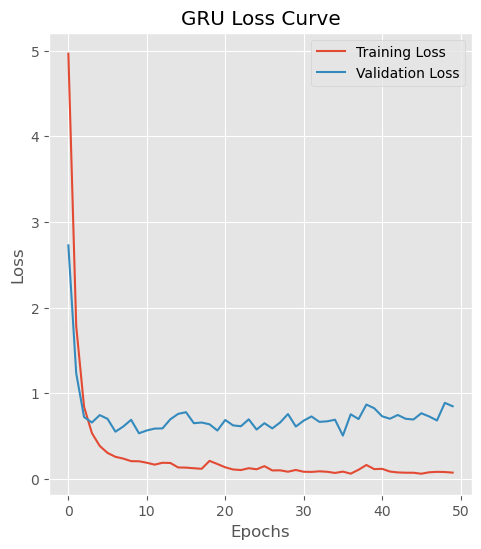

In [52]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_GRU.history['loss'], label = 'Training Loss')
plt.plot(history_GRU.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Loss Curve')
plt.legend()

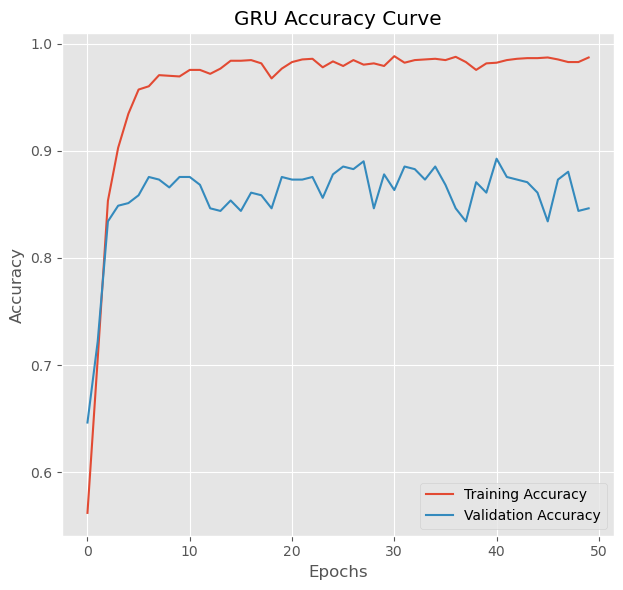

In [53]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_GRU.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_GRU.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('GRU Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# BERT Model

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay

In [ ]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [ ]:
def encode_texts(texts, tokenizer, max_length = 128):
    return tokenizer(
        texts,
        max_length = max_length,
        padding = 'max_length',
        truncation = True,
        return_tensors = 'tf'
    )

In [ ]:
X_train_enc = encode_texts(data['Text'].tolist(), tokenizer)
y = data['Class'].values

# Convert TensorFlow tensors to NumPy arrays
X_input_ids = X_train_enc['input_ids'].numpy()
X_attention_mask = X_train_enc['attention_mask'].numpy()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_input_ids, y, test_size=0.2, random_state=42
)
X_train_mask, X_test_mask, _, _ = train_test_split(
    X_attention_mask, y, test_size=0.2, random_state=42
)

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels = len(np.unique(y)))

In [ ]:
# Use AdamWeightDecay optimizer from transformers
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

# Compile the model
bert_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
bert_model.fit(
    {'input_ids': X_train, 'attention_mask': X_train_mask},
    y_train,
    validation_data=({'input_ids': X_test, 'attention_mask': X_test_mask}, y_test),
    epochs=5,
    batch_size=32,
)

# Display the model summary
bert_model.summary()